In [191]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from matplotlib import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.metrics import mean_absolute_error

from scipy.stats import boxcox

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
rcParams['figure.figsize'] = 18, 5
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['lines.linewidth'] = 2.5

In [192]:
df = pd.read_csv('data/eps_quarter.csv')

df.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    84 non-null     object 
 1   data    84 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.4+ KB


In [194]:
df['date'] = pd.to_datetime(df['date'])

# Set the date as the index
df.set_index('date', inplace=True)


# Display the dataframe
df.head()

,data
date,
1960-01-01,0.71
1960-04-01,0.63
1960-07-02,0.85
1960-10-01,0.44
1961-01-01,0.61


In [195]:
df.tail()

,data
date,
1979-10-01,9.99
1980-01-01,16.20
1980-04-01,14.67
1980-07-02,16.02
1980-10-01,11.61


## 📌 Plot the Time Series Data

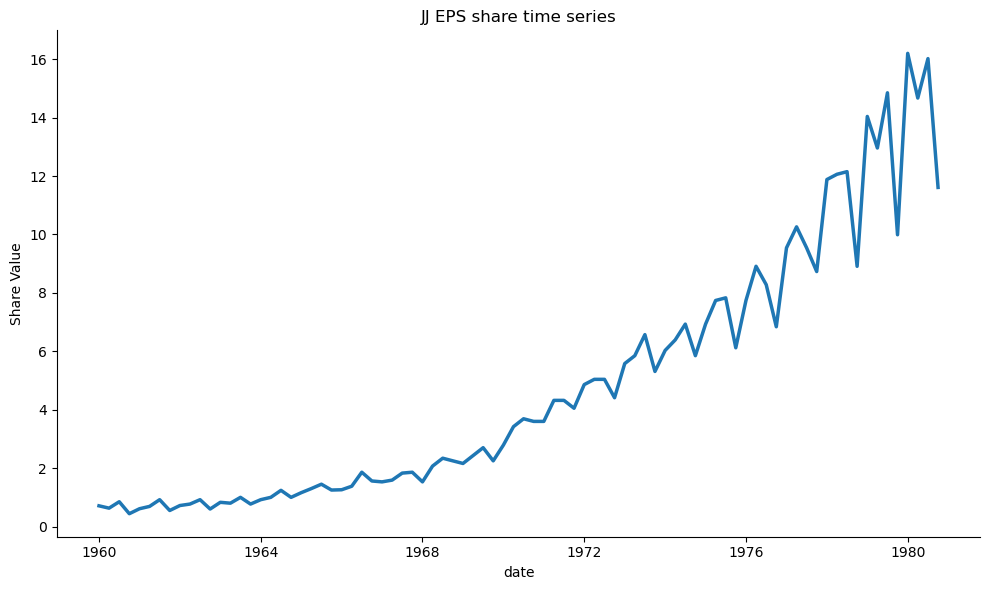

In [196]:
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['data'])
plt.title('JJ EPS share time series')

plt.xlabel('date')
plt.ylabel('Share Value')

plt.tight_layout()
plt.show()

## Check for Stationarity (Dickey-Fuller Test)

In [197]:
# ADF Test
def adf_test(series, alpha=0.05):
    """
    Performs the Augmented Dickey-Fuller (ADF) test on a time series.

    Parameters:
    - series (pd.Series): The time series data to test.
    - alpha (float): Significance level (default is 0.05).

    Returns:
    - None (prints the results)
    """
    result = adfuller(series)

    # Create results dictionary
    output = {
        'Test Statistic': result[0],
        'p-value': result[1],
        '# Lags Used': result[2],
        'Number of Observations': result[3],
    }

    # Add critical values
    for key, value in result[4].items():
        output[f'Critical Value ({key})'] = value

    # Convert to DataFrame for better readability
    output_df = pd.DataFrame(output.items(), columns=['Metric', 'Value'])

    # Print the results
    print("\n🔍 Results of Augmented Dickey-Fuller Test:")
    print(output_df.to_string(index=False))

    # Interpretation
    print("\n📌 Interpretation:")
    if result[1] <= alpha:
        print(f"✅ The time series is **stationary** (p-value = {result[1]:.5f} ≤ {alpha})")
    else:
        print(f"❌ The time series is **not stationary** (p-value = {result[1]:.5f} > {alpha})")

In [198]:
adf_test(df['data'])


🔍 Results of Augmented Dickey-Fuller Test:
                Metric     Value
        Test Statistic  2.742017
               p-value  1.000000
           # Lags Used 11.000000
Number of Observations 72.000000
   Critical Value (1%) -3.524624
   Critical Value (5%) -2.902607
  Critical Value (10%) -2.588679

📌 Interpretation:
❌ The time series is **not stationary** (p-value = 1.00000 > 0.05)


In [199]:

# train_size = int(len(df) * 0.9)  # 90% training, 10% testing
# train, test = df.iloc[:train_size], df.iloc[train_size:]


#split into train and test sets
X = df.values
size = int(len(X) * 0.95)
train, test = X[0:size], X[size:len(X)]


In [200]:
print(f"Training Size: {len(train)} quarters")
print(f"Test Size: {len(test)} quarters")

Training Size: 79 quarters
Test Size: 5 quarters


In [201]:
# # Plot the time series
# plt.figure(figsize=(10, 6))
# plt.plot(df.index, df['data'], label='Quarterly EPS Data')

# # Highlight the period corresponding to the test data
# plt.axvspan(train.index[-1], df.index[-1], color='orange', alpha=0.3, label='Test Data')

# # Add labels, title, and show legend
# plt.xlabel('Quarter')
# plt.ylabel('Quarterly EPS')
# plt.title('Quarterly EPS- JJ over 21 years- 84 quarters')
# plt.legend()

# plt.tight_layout()
# plt.show()

## Elimination of Non Stationarity

### Apply differencing

In [202]:
# create a differenced series
def trend_difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return np.array(diff)

In [204]:
# Apply differencing on just one column, assuming 'inflation' is the column of interest
eps_diff = trend_difference(df['data'].values, interval=1)

### Adfuller test to check stationarity of differenced series

In [205]:
adf_test(eps_diff)


🔍 Results of Augmented Dickey-Fuller Test:
                Metric     Value
        Test Statistic -0.407410
               p-value  0.908854
           # Lags Used 10.000000
Number of Observations 72.000000
   Critical Value (1%) -3.524624
   Critical Value (5%) -2.902607
  Critical Value (10%) -2.588679

📌 Interpretation:
❌ The time series is **not stationary** (p-value = 0.90885 > 0.05)


In [206]:
eps_diff2 = eps_diff = trend_difference(eps_diff, interval=1)


In [207]:
adf_test(eps_diff2)


🔍 Results of Augmented Dickey-Fuller Test:
                Metric     Value
        Test Statistic -3.585163
               p-value  0.006051
           # Lags Used  9.000000
Number of Observations 72.000000
   Critical Value (1%) -3.524624
   Critical Value (5%) -2.902607
  Critical Value (10%) -2.588679

📌 Interpretation:
✅ The time series is **stationary** (p-value = 0.00605 ≤ 0.05)


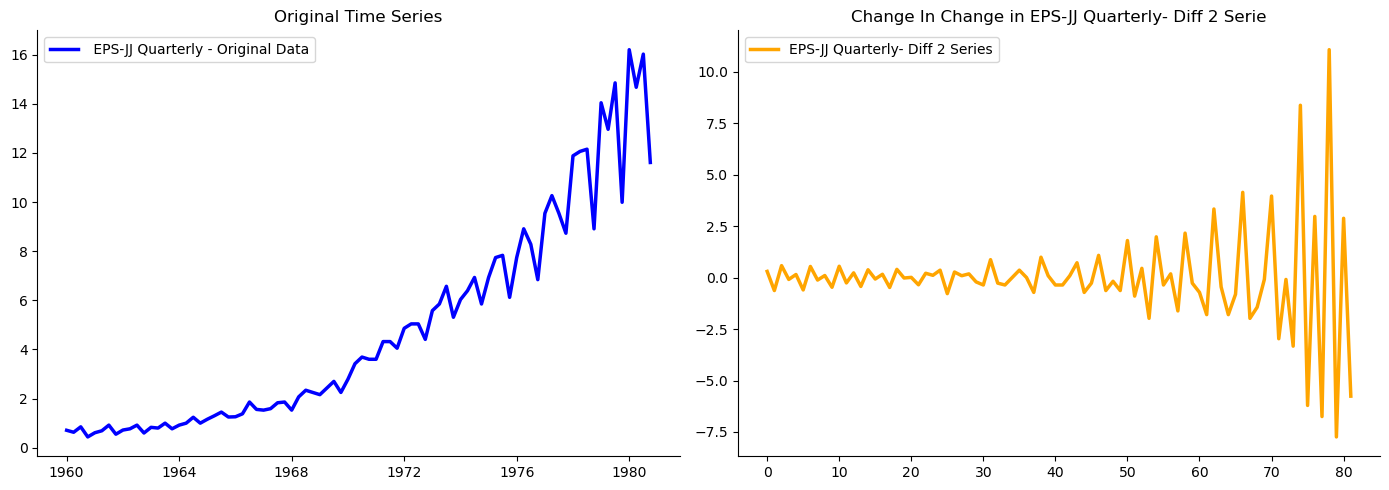

In [208]:
# plot before and after series
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original series
axes[0].plot(df, label=' EPS-JJ Quarterly - Original Data', color='blue')
axes[0].set_title('Original Time Series')
axes[0].legend()

# Box-Cox transformed series
axes[1].plot(eps_diff2, label="EPS-JJ Quarterly- Diff 2 Series", color='orange')
axes[1].set_title('Change In Change in EPS-JJ Quarterly- Diff 2 Serie')
axes[1].legend()

plt.tight_layout()
plt.show()

## Determine Lag Order (p,q,d=2)

### ACF PACF for Initial Analysis

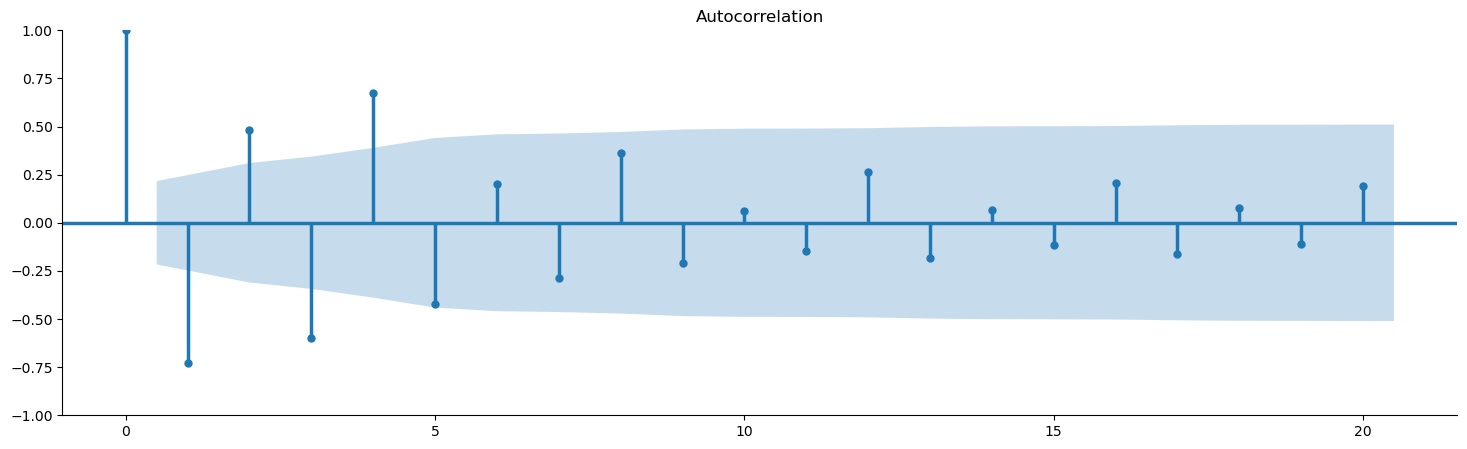

In [209]:
plot_acf(eps_diff2)
plt.show()

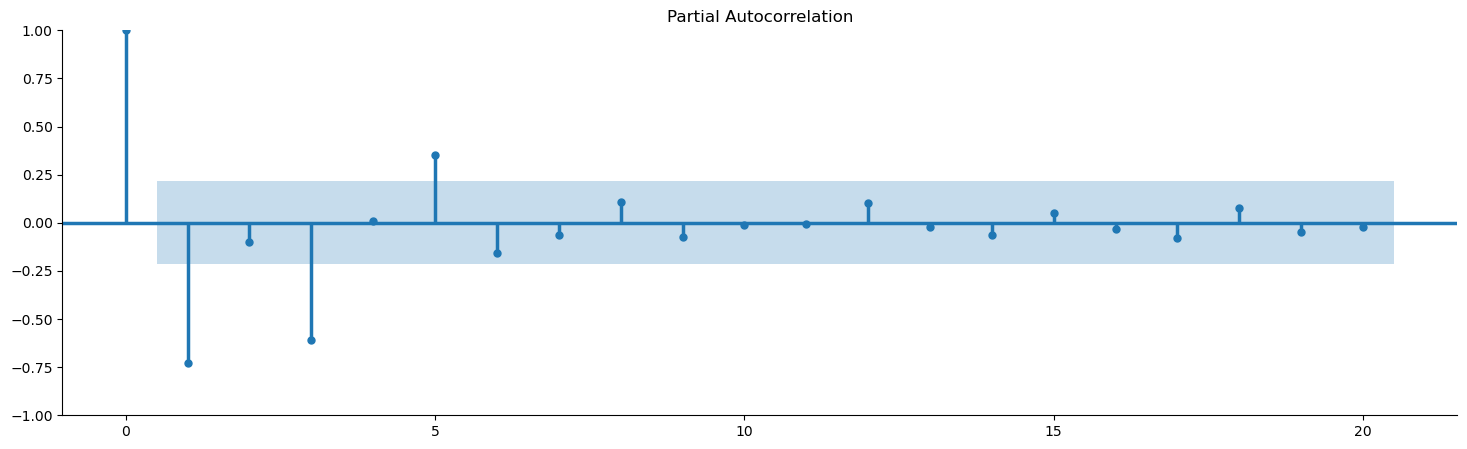

In [210]:
plot_pacf(eps_diff2)
plt.show()

## Train ARIMA Model

In [211]:
model = ARIMA(train, order=(3,2,3))
model_fit = model.fit()
residuals = model_fit.resid

In [212]:
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   79
Model:                 ARIMA(3, 2, 3)   Log Likelihood                 -49.070
Date:                Thu, 27 Feb 2025   AIC                            112.141
Time:                        17:40:14   BIC                            128.548
Sample:                             0   HQIC                           118.703
                                 - 79                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0152      0.048    -21.218      0.000      -1.109      -0.921
ar.L2         -1.0021      0.048    -20.783      0.000      -1.097      -0.908
ar.L3         -0.9707      0.031    -31.573      0.0

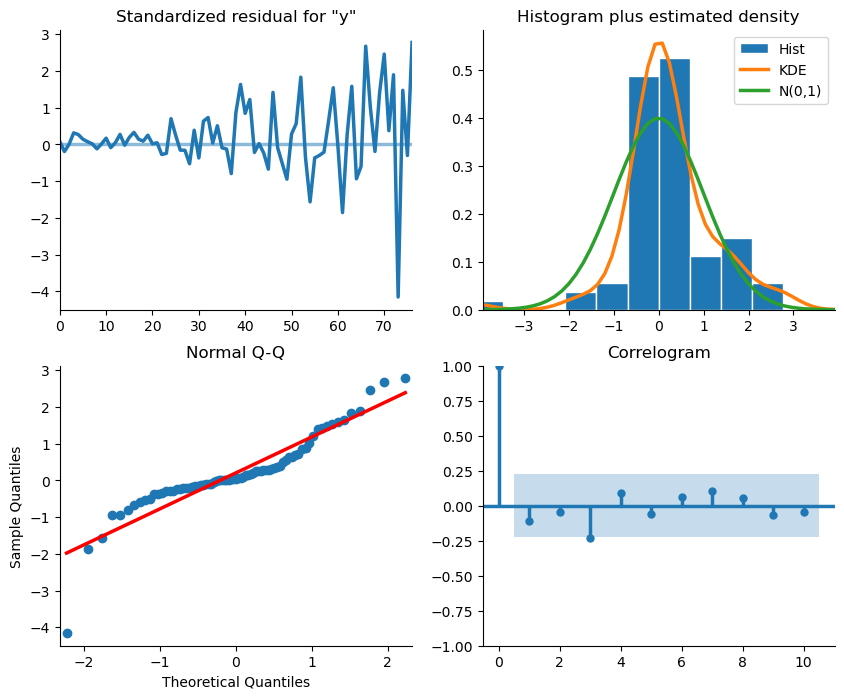

In [213]:
model_fit.plot_diagnostics(figsize=(10, 8));

## 🔹 Evaluate Model

In [214]:
# history = [x for x in train]  # Initial history from training set
# predictions = []
# for t in range(len(test)):
#     model=ARIMA(history,order=(3,2,3))
#     model_fit=model.fit()
#     output=model_fit.forecast()
#     yhat=output[0]
#     predictions.append(yhat)
#     obs=test[t]
#     history.append(obs)
#     print(f"Predicted={yhat}, Expected={obs}")

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

history = [x for x in train]  # Initial history from training set
predictions = []

for t in range(len(test)):
    model = ARIMA(history, order=(3,2,3))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print(f"Predicted={yhat}, Expected={obs}")



Predicted=10.810416041848534, Expected=[9.99]
Predicted=15.851246725227554, Expected=[16.2]
Predicted=14.41151152179686, Expected=[14.67]
Predicted=16.560155465850784, Expected=[16.02]
Predicted=11.76517229491381, Expected=[11.61]
